Import data from previous notebook and librairies

In [12]:
import pandas as pd
import shap
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from scipy.stats import uniform
from tqdm import tqdm
import time

pd.options.display.float_format = '{:.6f}'.format
data = pd.read_csv('X_clean.csv')

data.head()


,TotalGHGEmissions,SiteEnergyUse(kBtu),NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),Age,Latitude,Longitude,RatioElectricityUse,RatioNaturalGasUse,...,Residential Care Facility,Restaurant,Retail Store,Self-Storage Facility,Senior Care Community,Social/Meeting Hall,Strip Mall,Supermarket/Grocery Store,Urgent Care/Clinic/Other Outpatient,Worship Facility
0,249.980000,7226362.500000,1.000000,12,88434,97,47.612200,-122.337990,0.160041,0.001766,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,295.860000,8387933.000000,1.000000,11,88502,28,47.613170,-122.333930,0.113309,0.006134,...,0.000000,4622.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2089.280000,72587024.000000,1.000000,41,759392,55,47.613930,-122.338100,0.199973,0.000206,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,286.430000,6794584.000000,1.000000,10,61320,98,47.614120,-122.336640,0.119437,0.002666,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,505.010000,14172606.000000,1.000000,18,113580,44,47.613750,-122.340470,0.111020,0.006212,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Creation of class Data, where it setup all model, and have a public method run to benchmark differents model with the datasett using Kfold to try different setup of tain/test data.
All model use CV to setup best hyperparameters.
Here we do an export to make a test in next notebook.

In [13]:
class SHAPAnalyzer:
    def __init__(self, model, X_train, X_test, mode, name):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.mode = mode
        print(name)
    
    def calculate_and_plot_shap_global(self):
        if self.mode >= 4:
            explainer = shap.TreeExplainer(self.model)
        else:
            explainer = shap.LinearExplainer(self.model, self.X_train)
        shap_values = explainer(self.X_train)
        shap.summary_plot(shap_values, self.X_train)
        return shap_values
    
    def calculate_and_plot_shap_local(self, instance_index=0):
        if self.mode >= 4:
            explainer = shap.TreeExplainer(self.model)
        else:
            explainer = shap.LinearExplainer(self.model, self.X_train)
        shap_values = explainer(self.X_test)
        shap_values_instance = shap_values[instance_index]
        shap.force_plot(
            explainer.expected_value,
            shap_values_instance.values,
            self.X_test.iloc[instance_index],
            matplotlib=True
        )
        return shap_values_instance


In [14]:
class Data:
    def __init__(self, data, y_n):
        self.epoch = 5
        self.n_jobs = 10
        self.layout = {
            'linear R2': [],
            'ridge R2': [],
            'lasso R2': [],
            'elastic R2': [],
            'random forest R2': [],
            'xgboost R2': [],
            'ridge alpha': [],
            'lasso alpha': [],
            'elastic alpha': [],
            'elastic l1_ratio': [],
            'random forest params': [],
            'xgboost params': [],
            'linear time': [],
            'ridge time': [],
            'lasso time': [],
            'elastic time': [],
            'random forest time': [],
            'xgboost time': []
        }
        self.name_list = ['linear', 'ridge', 'lasso', 'elastic', 'random forest', 'xgboost']
        self.iter = 0
        self.origin = data.copy()
        self.y_n = y_n
        self.data = data
        self.y = self.data.iloc[:, y_n]
        self.data = self.data.iloc[:, 2:]
        print(f"Prediction {self.y.name}")
        
    def preprocess(self, train, test):
        scaler = StandardScaler()
        df_train = pd.DataFrame(scaler.fit_transform(train), columns=self.data.columns)
        df_test = pd.DataFrame(scaler.transform(test), columns=self.data.columns)
        return df_train, df_test
           
    def run(self):
        kf = KFold(n_splits=self.epoch, shuffle=True, random_state=42)
        self.models = [
            LinearRegression(),
            Ridge(),
            Lasso(),
            ElasticNet(),
            RandomForestRegressor(),
            xgb.XGBRegressor()
        ]
        total_steps_per_epoch = 6
        with tqdm(total=kf.get_n_splits() * total_steps_per_epoch, desc="Epoch Progress") as pbar:
            for train_index, test_index in kf.split(self.data):
                self.X_train, self.X_test = self.data.iloc[train_index], self.data.iloc[test_index]
                self.y_train, self.y_test = self.y.iloc[train_index], self.y.iloc[test_index]
                self.X_train, self.X_test = self.preprocess(self.X_train, self.X_test)
                self.models[0] = self.linear_regression(self.models[0])
                pbar.update(1)
                self.models[1] = self.ridge_regression(self.models[1])
                pbar.update(1)
                self.models[2] = self.lasso_regression(self.models[2])
                pbar.update(1)
                self.models[3] = self.elastic_net(self.models[3])
                pbar.update(1)
                self.models[4] = self.random_forest_regression(self.models[4])
                pbar.update(1)
                self.models[5] = self.xgboost_regression(self.models[5])
                pbar.update(1)
            for i in range(len(self.models)):
                explainer = SHAPAnalyzer(self.models[i], self.X_train, self.X_test, i, self.name_list[i])
                explainer.calculate_and_plot_shap_global()
                explainer.calculate_and_plot_shap_local()
        return self.layout

    def linear_regression(self, model):
        start_time = time.time()
        model.fit(self.X_train, self.y_train)
        pred = model.predict(self.X_test)
        explainer = shap.Explainer(model, self.X_train)
        shap_values = explainer(self.X_test)
        end_time = time.time()
        self.layout['linear R2'].append(r2_score(self.y_test, pred))
        self.layout['linear time'].append(end_time - start_time)
        shap.plots.force(shap_values[0])
        return model

    def ridge_regression(self, model):
        start_time = time.time()
        param_distributions_ridge = {'alpha': uniform(0.01, 1000)}
        random_search_ridge = RandomizedSearchCV(model, param_distributions_ridge, n_iter=20, cv=5, scoring='r2', n_jobs=self.n_jobs)
        random_search_ridge.fit(self.X_train, self.y_train)
        best_ridge = random_search_ridge.best_estimator_
        pred = best_ridge.predict(self.X_test)
        end_time = time.time()
        self.layout['ridge R2'].append(r2_score(self.y_test, pred))
        self.layout['ridge alpha'].append(random_search_ridge.best_params_['alpha'])
        self.layout['ridge time'].append(end_time - start_time)
        return best_ridge

    def lasso_regression(self, model):
        start_time = time.time()
        param_distributions_lasso = {'alpha': uniform(0.01, 1000)}
        random_search_lasso = RandomizedSearchCV(model, param_distributions_lasso, n_iter=20, cv=5, scoring='r2', n_jobs=self.n_jobs)
        random_search_lasso.fit(self.X_train, self.y_train)
        best_lasso = random_search_lasso.best_estimator_
        pred = best_lasso.predict(self.X_test)
        end_time = time.time()
        self.layout['lasso R2'].append(r2_score(self.y_test, pred))
        self.layout['lasso alpha'].append(random_search_lasso.best_params_['alpha'])
        self.layout['lasso time'].append(end_time - start_time)
        return best_lasso

    def elastic_net(self, model):
        start_time = time.time()
        param_distributions_elastic_net = {
            'alpha': uniform(0.01, 1000),
            'l1_ratio': uniform(0, 1)
        }
        random_search_elastic_net = RandomizedSearchCV(model, param_distributions_elastic_net, n_iter=20, cv=5, scoring='r2', n_jobs=self.n_jobs)
        random_search_elastic_net.fit(self.X_train, self.y_train)
        best_elastic_net = random_search_elastic_net.best_estimator_
        pred = best_elastic_net.predict(self.X_test)
        end_time = time.time()
        self.layout['elastic R2'].append(r2_score(self.y_test, pred))
        self.layout['elastic alpha'].append(random_search_elastic_net.best_params_['alpha'])
        self.layout['elastic l1_ratio'].append(random_search_elastic_net.best_params_['l1_ratio'])
        self.layout['elastic time'].append(end_time - start_time)
        return best_elastic_net

    def random_forest_regression(self, model):
        start_time = time.time()
        param_grid_rf = {
            'n_estimators': [50, 100],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
        random_search_rf = GridSearchCV(model, param_grid_rf, cv=5, scoring='r2', n_jobs=self.n_jobs)
        random_search_rf.fit(self.X_train, self.y_train)
        best_rf = random_search_rf.best_estimator_
        pred = best_rf.predict(self.X_test)
        end_time = time.time()
        self.layout['random forest R2'].append(r2_score(self.y_test, pred))
        self.layout['random forest params'].append(random_search_rf.best_params_)
        self.layout['random forest time'].append(end_time - start_time)
        return best_rf

    def xgboost_regression(self, model):
        start_time = time.time()
        param_distributions_xgb = {
            'n_estimators': [10, 50, 100],
            'max_depth': [3, 6, 10],
            'learning_rate': uniform(0.01, 0.3),
            'alpha': uniform(0, 1)
        }
        random_search_xgb = RandomizedSearchCV(model, param_distributions_xgb, n_iter=20, cv=5, scoring='r2', n_jobs=self.n_jobs)
        random_search_xgb.fit(self.X_train, self.y_train)
        best_xgb = random_search_xgb.best_estimator_
        pred = best_xgb.predict(self.X_test)
        end_time = time.time()
        self.layout['xgboost R2'].append(r2_score(self.y_test, pred))
        self.layout['xgboost params'].append(random_search_xgb.best_params_)
        self.layout['xgboost time'].append(end_time - start_time)
        return best_xgb

Transorme the result from the class method run to dataframe to use it later and run the tests

Prediction SiteEnergyUse(kBtu)


Epoch Progress: 100%|██████████| 30/30 [04:22<00:00, 10.77s/it]

linear


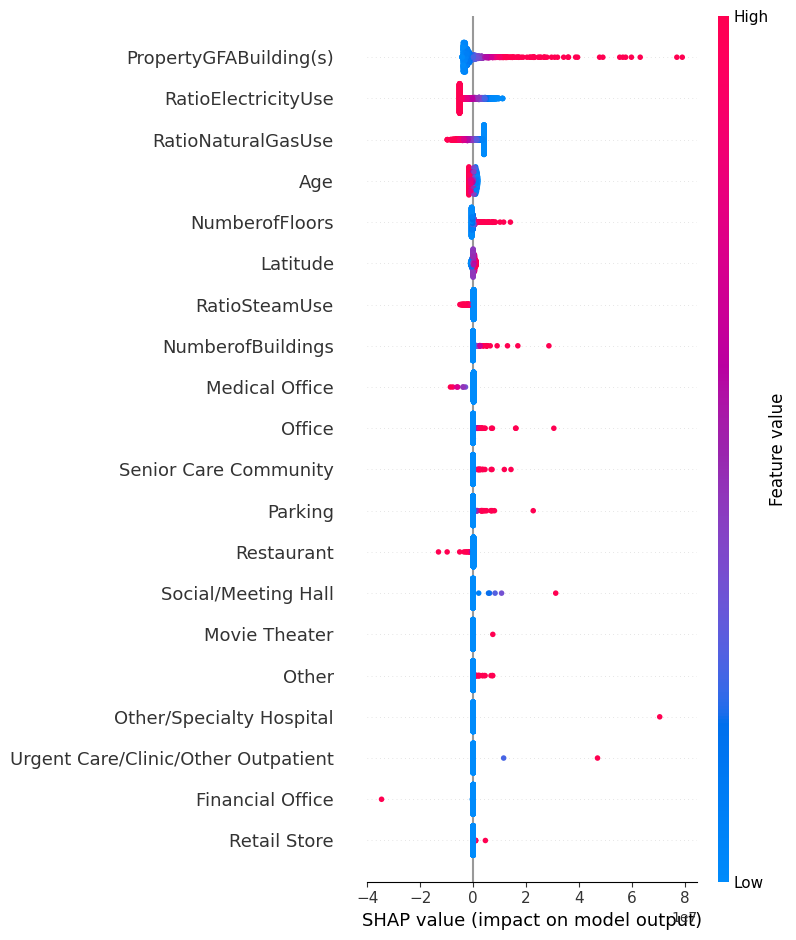

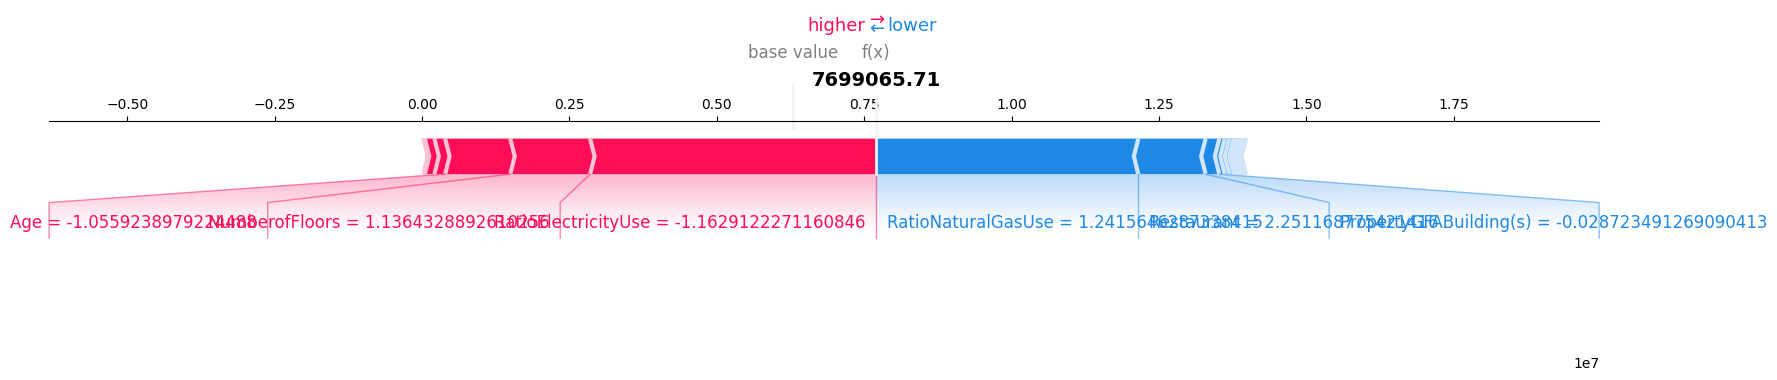

ridge


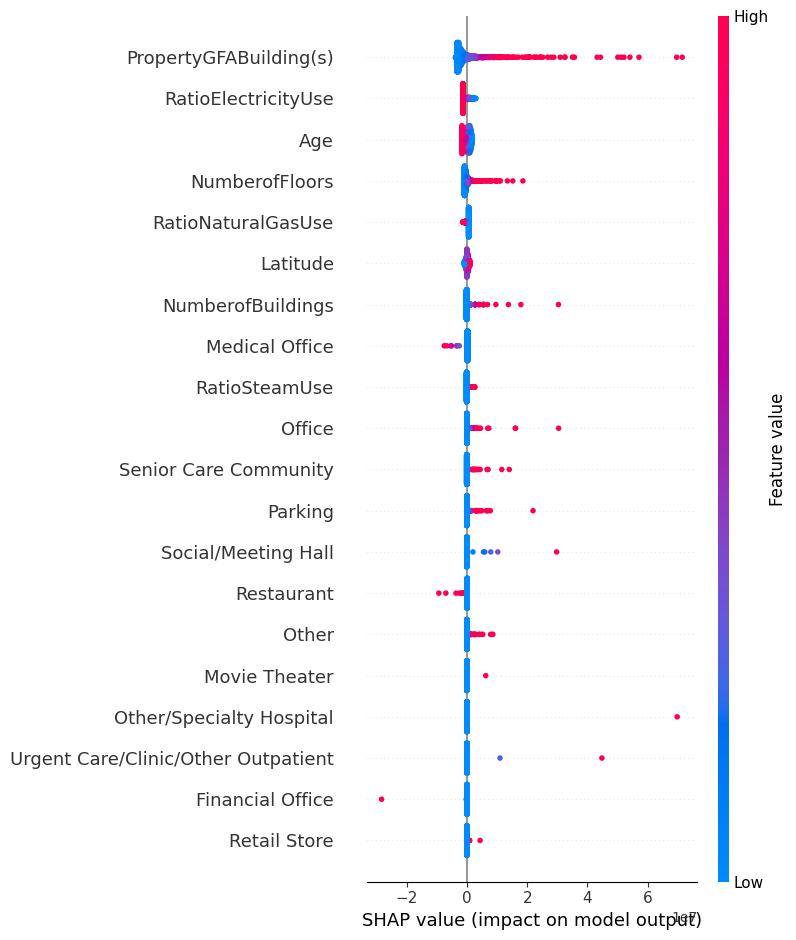

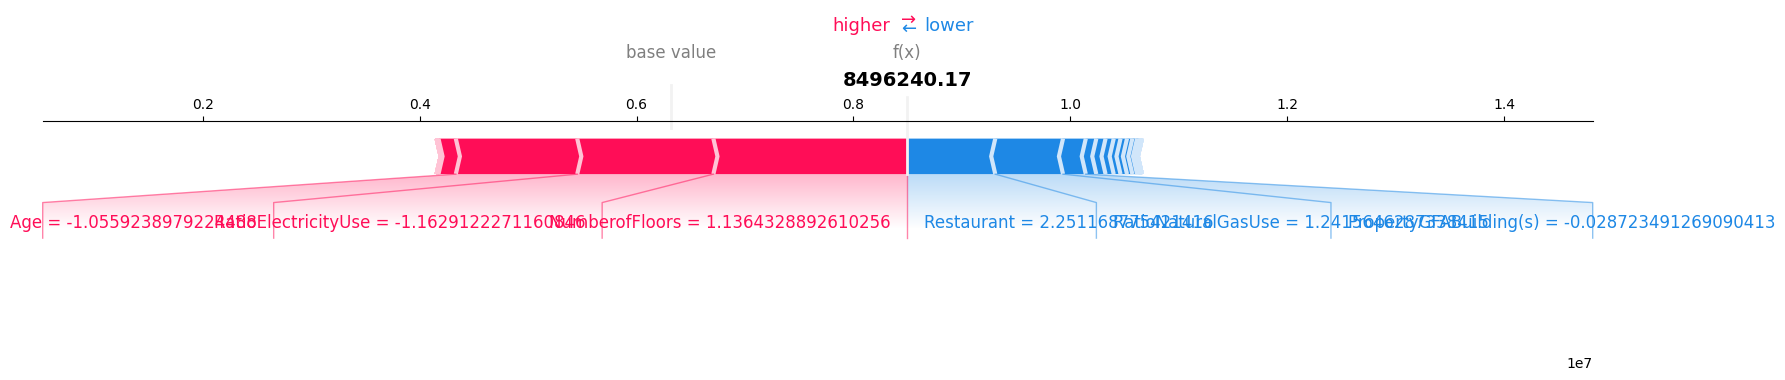

lasso


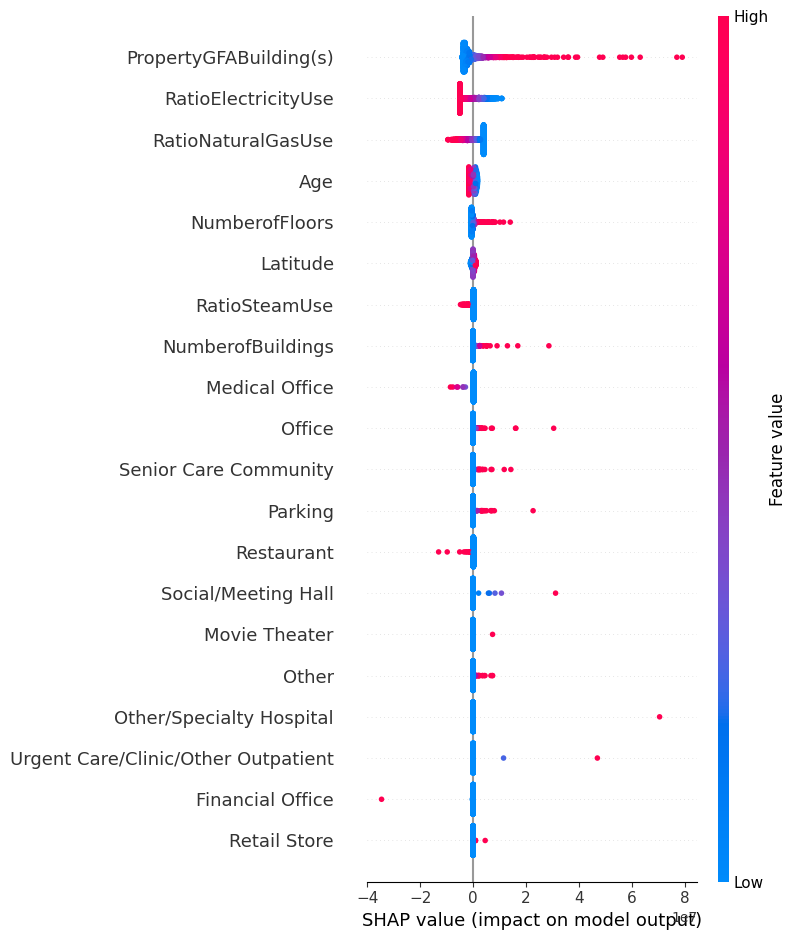

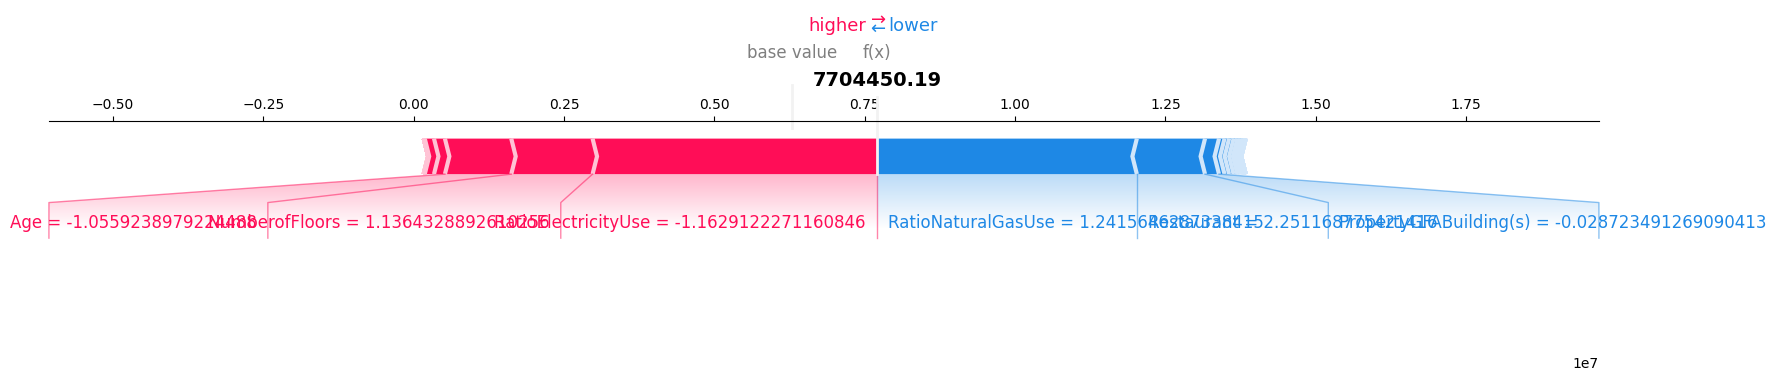

elastic


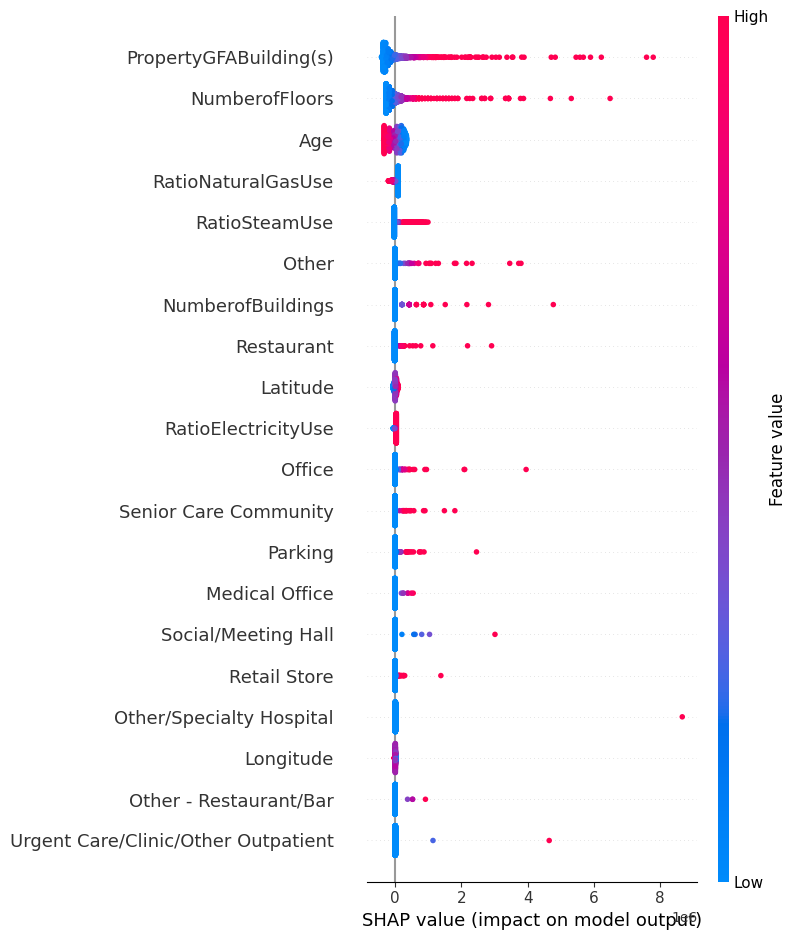

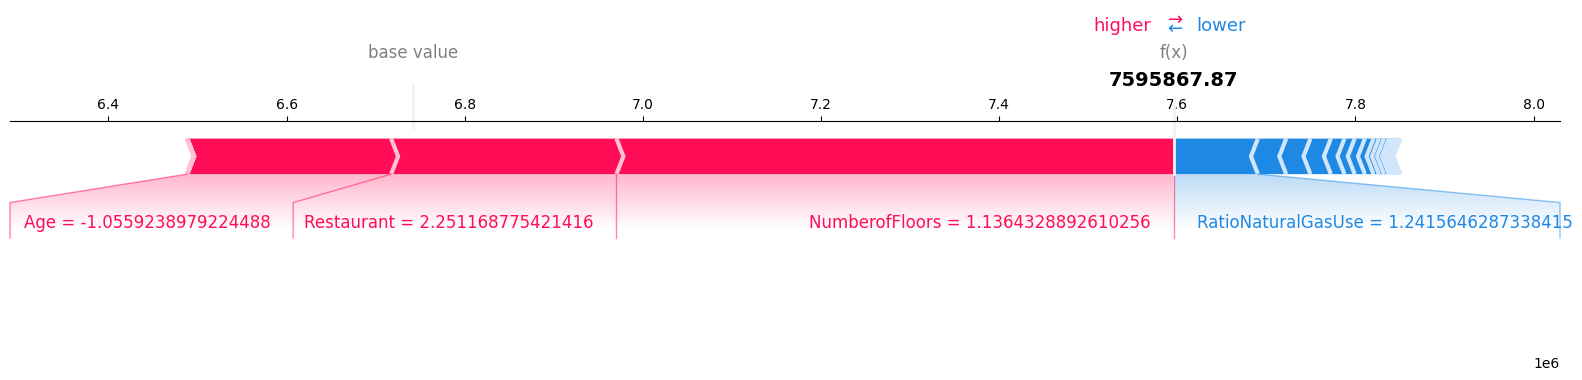

random forest


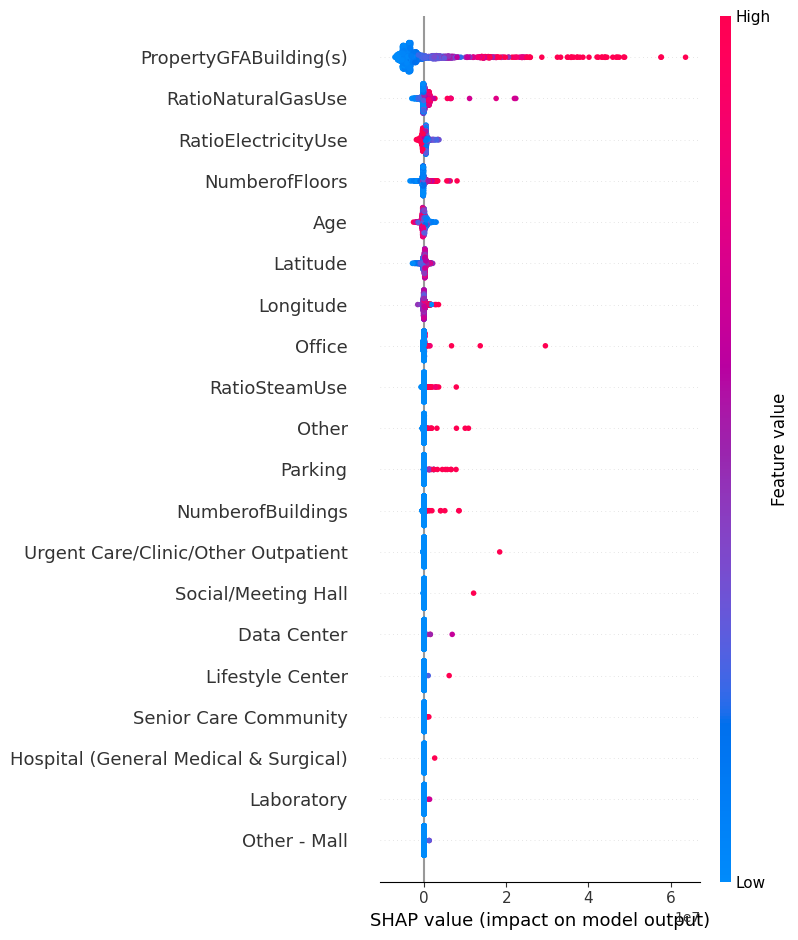

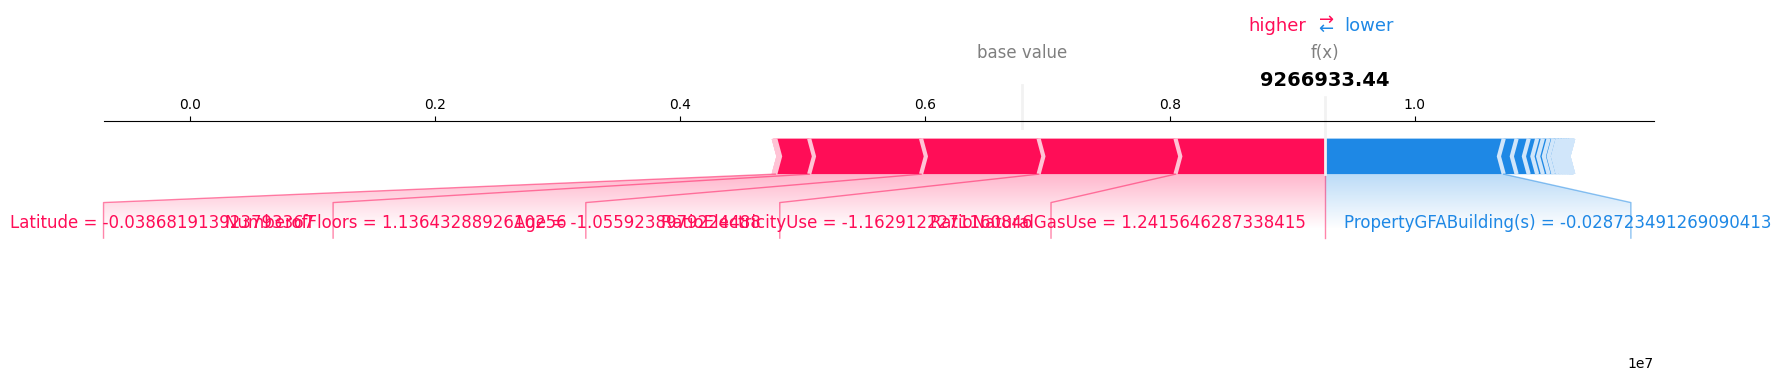

xgboost


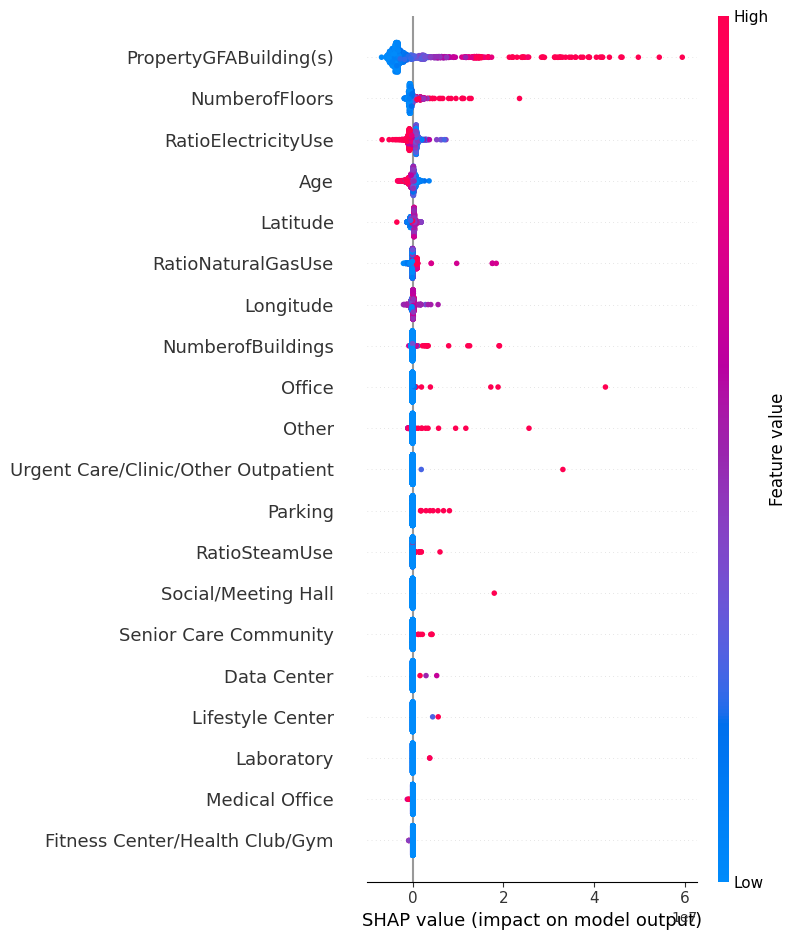

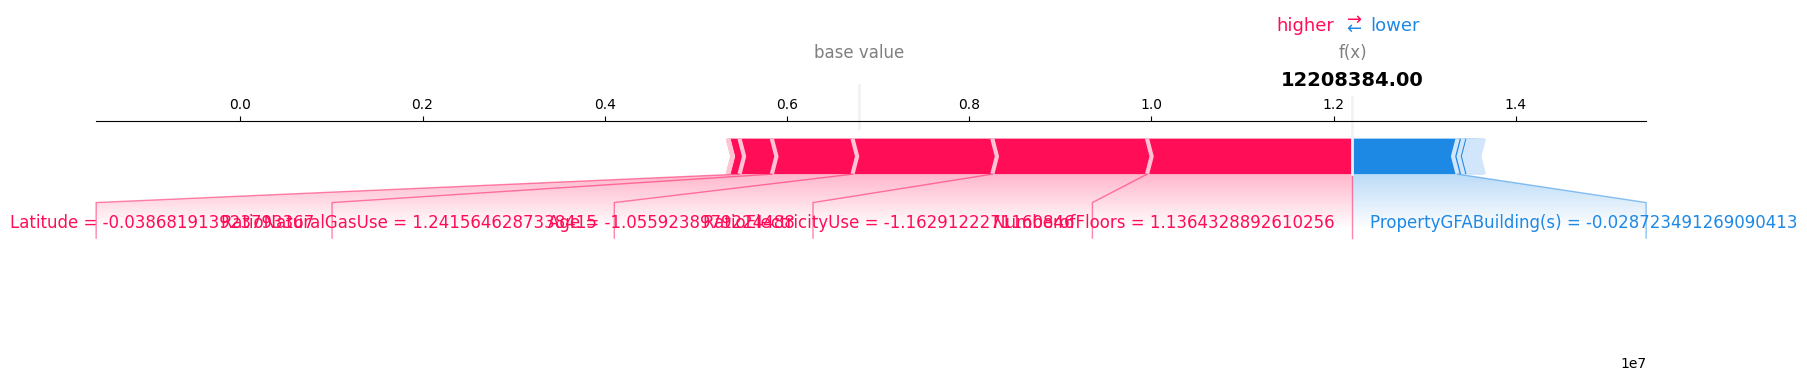

Epoch Progress: 100%|██████████| 30/30 [04:40<00:00,  9.36s/it]


,linear R2,ridge R2,lasso R2,elastic R2,random forest R2,xgboost R2,ridge alpha,lasso alpha,elastic alpha,elastic l1_ratio,random forest params,xgboost params,linear time,ridge time,lasso time,elastic time,random forest time,xgboost time
0,-489052808808258336669992747008.000000,0.643542,0.594625,0.119236,0.609994,0.618675,191.889453,992.414591,699.960606,0.970261,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.6462491514380668, 'learning_rate':...",6.577253,0.658679,2.196680,0.659630,31.330597,22.032287
1,-215523860269327682375778304.000000,0.550939,0.548742,0.052019,0.552786,0.566995,105.007511,2.263275,501.430195,0.941367,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.41270873751781434, 'learning_rate'...",1.046682,0.334520,1.299017,0.416353,27.400661,21.252440
2,0.509253,0.516747,0.509689,0.306153,0.679429,0.655178,229.747976,986.761142,5.056747,0.509536,"{'max_depth': 20, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.10253721509532454, 'learning_rate'...",1.455769,0.366879,1.197950,0.431718,29.996210,18.042080
3,-2620955248209265032702415863808.000000,0.460160,0.440486,0.364843,0.590531,0.618419,110.805522,975.640092,51.258235,0.970431,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.9792374182071737, 'learning_rate':...",1.259167,0.400479,1.241660,0.391789,29.102915,22.823130
4,0.462532,0.483513,0.462702,0.177590,0.748393,0.740159,59.815354,989.575209,58.044003,0.831042,"{'max_depth': 10, 'min_samples_leaf': 1, 'min_...","{'alpha': 0.8556000803666085, 'learning_rate':...",1.143293,0.343280,1.740169,0.831890,26.365579,10.296215


In [15]:
import time
df = Data(data, 1)

res = pd.DataFrame(df.run())
res.head()

Calculation of means to compare all model and visualisation - R2

              index         0
0         linear R2 -0.405643
1          ridge R2  0.530980
2          lasso R2  0.511249
3        elastic R2  0.203968
4  random forest R2  0.636227
5        xgboost R2  0.639885


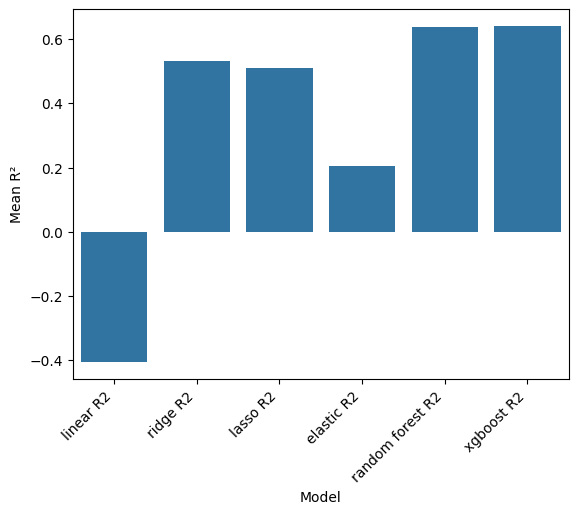

In [16]:
list_r2  = ['linear R2', 'ridge R2', 'lasso R2', 'elastic R2','random forest R2','xgboost R2']
res[list_r2] = res[list_r2].clip(lower=-1, upper=1)

scores_r2 = res[list_r2].mean().reset_index()
print(scores_r2)
scores_r2.columns = ['Model', 'Mean R²']
sns.barplot(x='Model', y='Mean R²', data=scores_r2)
plt.xticks(rotation=45, ha='right')
plt.show()

xgboost have the best score but Random forest and ridge are very close

Calculation of means to compare all model and visualisation - time

                index         0
0         linear time  2.296433
1          ridge time  0.420767
2          lasso time  1.535095
3        elastic time  0.546276
4  random forest time 28.839192
5        xgboost time 18.889230


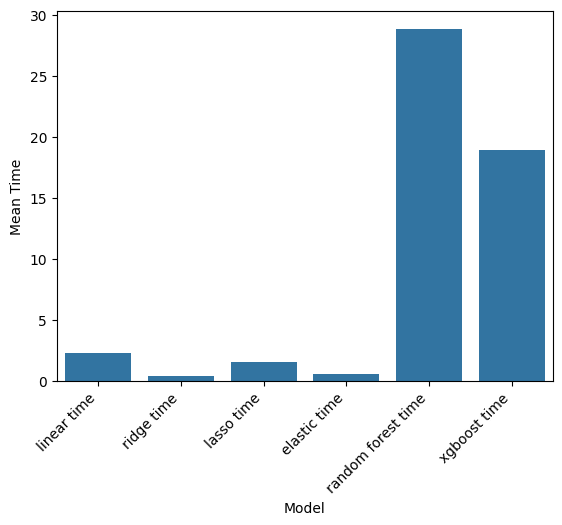

In [17]:
time = res[['linear time',	'ridge time',	'lasso time',	'elastic time',	'random forest time',	'xgboost time']].mean().reset_index()
print(time)
time.columns = ['Model', 'Mean Time']
sns.barplot(x='Model', y='Mean Time', data=time)
plt.xticks(rotation=45, ha='right')
plt.show()

the ones with the best time have very bad R2 score, so we keep only these 2 : ridge, xgboost
- ridge R2 : 0.931337 time : 0.316923
- xgboost R2 : 0.950739 time : 2.491651

- The best model is xgboost
- the most efficient model is ridge